# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-01-29/data_eval_new/"
file_name = "int_norm_20160129_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

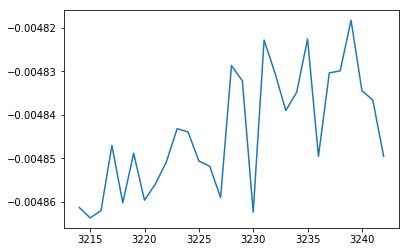

In [7]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

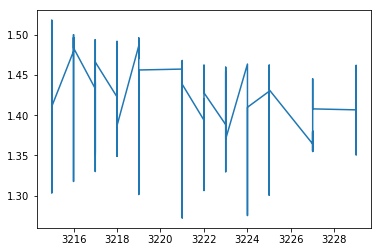

In [8]:
# Check Signals
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [9]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 100ppb', 'SPEX 100ppb'], dtype=object)

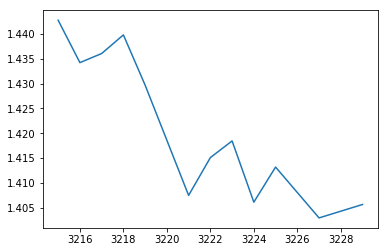

In [10]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

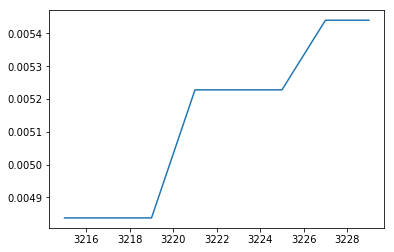

In [11]:
# Check background 
column = "120"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [12]:
background_mean = df_mean(background)

In [13]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [14]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [93]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [94]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [95]:
column = "124/120"
sample = "NIST 100ppb"

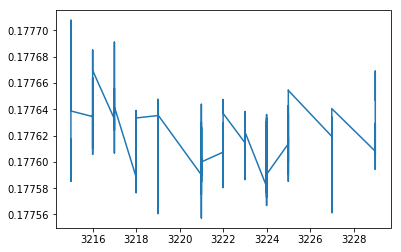

In [96]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [97]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [98]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-01-29 16:58:00,NIST 100ppb,2,1,3215,0.029844,0.020209,0.010362,0.446017,0.235288,0.742935,0.263427,0.142121,0.177617
2016-01-29 16:58:00,NIST 100ppb,2,2,3215,0.029838,0.020189,0.010358,0.446048,0.235310,0.742935,0.263412,0.142084,0.177611
2016-01-29 16:58:00,NIST 100ppb,2,3,3215,0.029841,0.020192,0.010363,0.446076,0.235299,0.742935,0.263413,0.142095,0.177585
2016-01-29 16:58:00,NIST 100ppb,2,4,3215,0.029825,0.020183,0.010364,0.446058,0.235282,NaN,0.263440,0.142117,0.177624
2016-01-29 16:58:00,NIST 100ppb,2,5,3215,0.029826,0.020190,0.010368,0.445998,0.235273,0.742935,0.263426,0.142109,0.177616
2016-01-29 16:58:00,NIST 100ppb,2,6,3215,0.029833,0.020189,0.010363,0.446034,0.235288,0.742935,0.263419,0.142110,0.177615
2016-01-29 16:58:00,NIST 100ppb,2,7,3215,0.029833,0.020195,0.010360,0.446033,0.235284,NaN,0.263433,0.142109,0.177634
2016-01-29 16:58:00,NIST 100ppb,2,8,3215,0.029832,0.020192,0.010362,0.446056,0.235291,0.742935,0.263426,0.142114,0.177635
2016-01-29 16:58:00,NIST 100ppb,2,9,3215,0.029818,0.020184,0.010364,0.446030,0.235297,0.742935,0.263411,0.142109,0.177628


In [99]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
3240        2016-01-29 23:43:00    0.177658
Name: 124/120, dtype: float64

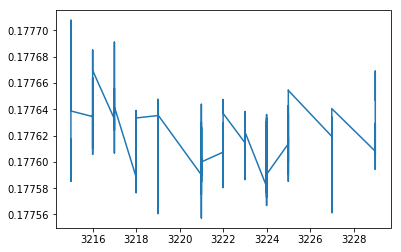

In [100]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [101]:
df[df["Sample"] == sample][column].std()

2.6101091078325047e-05

In [102]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [103]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

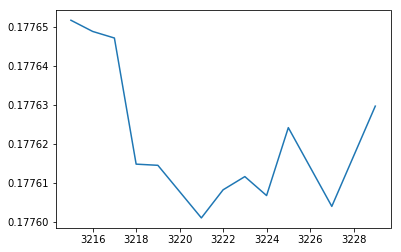

In [104]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [105]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2016-01-29 16:58:00,3215,NIST 100ppb,0.029837,0.020195,0.010365,0.446036,0.235283,0.742935,0.263406,0.142129,0.177652,0.000102,0.000047
2016-01-29 17:15:00,3216,NIST 100ppb,0.029836,0.020196,0.010363,0.446047,0.235287,0.742935,0.263409,0.142126,0.177649,0.000100,0.000065
2016-01-29 17:33:00,3217,NIST 100ppb,0.029834,0.020196,0.010365,0.446047,0.235288,0.742935,0.263414,0.142125,0.177647,0.000097,0.000054
2016-01-29 17:50:00,3218,NIST 100ppb,0.029835,0.020196,0.010362,0.446052,0.235294,0.742935,0.263418,0.142110,0.177615,0.000095,0.000063
2016-01-29 18:07:00,3219,NIST 100ppb,0.029835,0.020193,0.010363,0.446050,0.235295,0.742935,0.263418,0.142106,0.177615,0.000098,0.000062
2016-01-29 18:35:00,3221,NIST 100ppb,0.029830,0.020190,0.010363,0.446036,0.235293,0.742935,0.263422,0.142100,0.177601,0.000097,0.000077
2016-01-29 18:52:00,3222,NIST 100ppb,0.029833,0.020193,0.010366,0.446044,0.235294,0.742935,0.263420,0.142104,0.177608,0.000100,0.000064
2016-01-29 19:09:00,3223,NIST 100ppb,0.029832,0.020193,0.010363,0.446040,0.235293,0.742935,0.263422,0.142104,0.177612,0.000094,0.000066
2016-01-29 19:26:00,3224,NIST 100ppb,0.029833,0.020191,0.010364,0.446035,0.235291,0.742935,0.263418,0.142103,0.177607,0.000095,0.000083


In [106]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [107]:
drop_sum = []

In [108]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [109]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [110]:
data_mean_int_sum

112/120                   114/120                   115/120  \
                 mean       SD2 count      mean       SD2 count      mean   
Sample                                                                      
NIST 100ppb  0.029834  0.000004    12  0.020193  0.000004    12  0.010364   
SPEX 100ppb  0.029827  0.000004    11  0.020188  0.000005    11  0.010372   

                              116/120  ...  122/120   124/120                  \
                  SD2 count      mean  ...    count      mean       SD2 count   
Sample                                 ...                                      
NIST 100ppb  0.000003    12  0.446042  ...       12  0.177622  0.000037    12   
SPEX 100ppb  0.000001    11  0.446022  ...       11  0.177614  0.000010    11   

                Cd/Sn                     Te/Sn                  
                 mean       SD2 count      mean       SD2 count  
Sample                                                           
NIST 100ppb  0.000096  0.000008    12  0.000064  0.000019    12  
SPEX 100ppb  0.000085  0.000007    11  0.000061  0.000012    11  

[2 rows x 33 columns]

In [111]:
date_list = []

epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [112]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_SPEX = epsilon_int_SPEX.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [113]:
epsilon_int_NIST[epsilon_int_NIST["Filenumber"] > 1]

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-01-29 18:35:00,1.552554,-1.236651,-1.644506,-1.975343,-0.245677,-0.054636,0.0,0.10375,-0.324724,-0.583066,NIST 100ppb


In [114]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)
epsilon_int_SPEX = epsilon_int_SPEX.drop(date_list)
delta_raw_SPEX = delta_raw_SPEX.drop(date_list)

In [115]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [116]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)


/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [117]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-01-29 20:46:00,3229,0.835638,1.490879,-9.318921,0.264326,0.039936,-1.110223e-12,-0.394322,0.808975,1.078174,NIST 100ppb
2016-01-29 21:31:00,3232,0.271460,1.779403,0.590316,0.004361,0.181775,-1.110223e-12,-0.134942,0.299909,0.179965,SPEX 100ppb
2016-01-29 21:49:00,3233,-0.846775,-1.499993,0.392570,0.101336,-0.118926,2.220446e-12,-0.183420,0.182064,0.413953,SPEX 100ppb
2016-01-29 22:06:00,3234,0.387542,-0.784911,0.377110,-0.083912,-0.034078,-1.110223e-12,0.176410,-0.384075,-0.394272,SPEX 100ppb
2016-01-29 22:23:00,3235,0.849561,2.272179,-1.854971,0.000514,0.032056,0.000000e+00,-0.288917,0.470824,0.400946,SPEX 100ppb
2016-01-29 22:51:00,3237,-1.269329,-1.928168,1.680856,0.125167,0.092429,0.000000e+00,0.431368,-0.433536,-0.521286,SPEX 100ppb
2016-01-29 23:08:00,3238,0.347792,0.195736,-0.763412,-0.089632,-0.144571,0.000000e+00,-0.151692,0.207255,0.316481,SPEX 100ppb
2016-01-29 23:25:00,3239,0.482849,1.644546,-0.108446,-0.085180,0.105318,-1.110223e-12,-0.173856,-0.038210,-0.023133,SPEX 100ppb
2016-01-29 23:43:00,3240,-0.428519,-2.155275,0.218298,0.055656,-0.055508,0.000000e+00,0.177209,0.019815,0.080568,SPEX 100ppb


In [118]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum.append(epsilon_SPEX_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum.append(delta_raw_SPEX_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [119]:
epsilon_sum_all

112/120              114/120              115/120               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 100ppb   0.006  1.192    10   0.011  2.549    10   0.093  3.777    10   
SPEX 100ppb  -1.476    NaN     1  -2.257    NaN     1   7.769    NaN     1   
NIST 100ppb   0.836    NaN     1   1.491    NaN     1  -9.319    NaN     1   
SPEX 100ppb  -0.026  1.475     8  -0.060  3.568     8   0.067  2.073     8   

            116/120  ...  118/120 119/120              122/120               \
               mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample               ...                                                      
NIST 100ppb   0.009  ...       10   0.028  0.402    10  -0.060  1.017    10   
SPEX 100ppb  -0.104  ...        1   0.024    NaN     1  -0.239    NaN     1   
NIST 100ppb   0.264  ...        1  -0.394    NaN     1   0.809    NaN     1   
SPEX 100ppb   0.004  ...        8  -0.018  0.498     8   0.041  0.638     8   

            124/120               
               mean    SD2 count  
Sample                            
NIST 100ppb  -0.081  1.524    10  
SPEX 100ppb  -0.145    NaN     1  
NIST 100ppb   1.078    NaN     1  
SPEX 100ppb   0.057  0.706     8  

[4 rows x 27 columns]

In [120]:
delta_raw_sum_all

112/120              114/120              115/120               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 100ppb  -0.007  0.279    10  -0.004  0.428    10   0.005  0.388    10   
SPEX 100ppb  -1.054    NaN     1  -0.884    NaN     1   0.215    NaN     1   
NIST 100ppb   1.121    NaN     1   0.913    NaN     1  -0.289    NaN     1   
SPEX 100ppb  -0.003  0.213     9  -0.003  0.364     9  -0.004  0.198     9   

            116/120  ...  118/120 119/120              122/120               \
               mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample               ...                                                      
NIST 100ppb  -0.003  ...       10   0.002  0.020    10  -0.004  0.045    10   
SPEX 100ppb  -0.456  ...        1  -0.107    NaN     1   0.193    NaN     1   
NIST 100ppb   0.537  ...        1   0.086    NaN     1  -0.168    NaN     1   
SPEX 100ppb  -0.005  ...        9   0.001  0.039     9   0.001  0.040     9   

            124/120               
               mean    SD2 count  
Sample                            
NIST 100ppb  -0.005  0.067    10  
SPEX 100ppb   0.417    NaN     1  
NIST 100ppb  -0.386    NaN     1  
SPEX 100ppb   0.002  0.034     9  

[4 rows x 27 columns]

In [77]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST.append(epsilon_int_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST.append(delta_raw_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [56]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [57]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [121]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [122]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.append(epsilon_int_SPEX).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.append(delta_raw_SPEX).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [123]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [124]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined